In [78]:
import re
import cv2
import nltk
import json
import keras
import pickle
import string
import numpy as np
import pandas as pd
import collections
from time import time
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.layers.merge import add
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

### Data Collection

In [79]:
# Read Text Captions
def readFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [80]:
captions = readFile('./flickr-image-dataset/results.csv')
captions = captions.split('\n')[1:]
print(len(captions))
print(captions[0])

158915
1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [81]:
# Dictionary to map each Image with its List of Captions
description = {}
train = []
for ix in captions:
    idata = ix.split('|')
    img = idata[0].split('.')[0]
    if description.get(img) is None:
        description[img] = []
        train.append(img)
    description[img].append(idata[2])

In [82]:
description['2199200615']

[' A dog running on green grass with its mouth open and tongue hanging out .',
 ' a white dog is running with its mouth open across the grass .',
 ' A white , black , and brown dog runs in a field .',
 ' A dog runs across the grassy field .',
 ' A dog runs across the grass .']

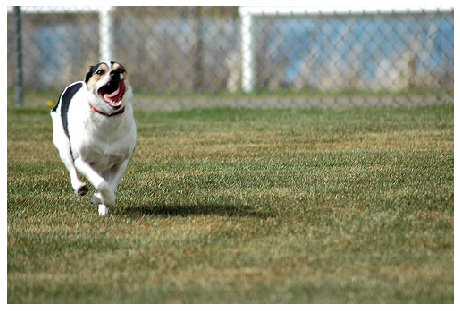

In [83]:
plt.style.use('seaborn')
IMG_PATH = './flickr-image-dataset/flickr30k_images/'
img = cv2.imread(IMG_PATH+'2199200615.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

### Data Cleaning

In [84]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ',sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = ' '.join(sentence)
    return sentence

In [85]:
# Cleaning all captions
for img,cap_list in description.items():
    for i in range(len(cap_list)):
        cap_list[i] = clean_text(cap_list[i])

In [138]:
description['2199200615']

['dog running on green grass with its mouth open and tongue hanging out',
 'white dog is running with its mouth open across the grass',
 'white black and brown dog runs in field',
 'dog runs across the grassy field',
 'dog runs across the grass']

In [87]:
# Save the cleaned data in file
with open('descriptions.txt','w') as f:
    f.write(str(description))

### Building The Vocabulary

In [88]:
descriptions = None
with open('descriptions.txt','r') as f:
    descriptions = f.read()
descriptions = json.loads(descriptions.replace("'","\""))
print(type(descriptions))

<class 'dict'>


In [89]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print('Vocabulary size : {}'.format(len(vocab)))

Vocabulary size : 18054


In [90]:
# Total no of words across all sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(word) for sent in descriptions[key] for word in sent.split()]
print('Total no of words : {}'.format(len(total_words)))

Total no of words : 1679080


In [91]:
# Find the count of each word
counter = collections.Counter(total_words)
freq_count = dict(counter)
print(len(freq_count.keys()))

18054


In [92]:
# Filter words from vocab acc to certain threshold frequency
sorted_freq_count = sorted(freq_count.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_freq_count = [x for x in sorted_freq_count if x[1]>threshold]
total_unique_words = [x[0] for x in sorted_freq_count]
print(len(total_unique_words))

5118


### Preparing Data

In [93]:
# Add <s> and <e> to our the data
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        train_descriptions[img_id].append('startseq '+cap+' endseq')

In [140]:
with open("./models/encoded_captions.pkl",'wb') as f:
    pickle.dump(train_descriptions,f)
train_descriptions['2199200615']

['startseq dog running on green grass with its mouth open and tongue hanging out endseq',
 'startseq white dog is running with its mouth open across the grass endseq',
 'startseq white black and brown dog runs in field endseq',
 'startseq dog runs across the grassy field endseq',
 'startseq dog runs across the grass endseq']

###  Image Feature Extraction ( ResNet50 Model )

In [95]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [96]:
new_model = Model(model.input,model.layers[-2].output)

In [97]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [98]:
# Encoding Training Images
start = time()
encoded_img = {}
for ix,img_id in enumerate(train):
    img_path = IMG_PATH+img_id+'.jpg'
    encoded_img[img_id] = encode_image(img_path)
    if ix%100 == 0:
        print('Train Encoding in Progress, Time Step : %d'%ix)
end = time()
print('Total Time Taken : ',end-start)

Train Encoding in Progress, Time Step : 0
Train Encoding in Progress, Time Step : 100
Train Encoding in Progress, Time Step : 200
Train Encoding in Progress, Time Step : 300
Train Encoding in Progress, Time Step : 400
Train Encoding in Progress, Time Step : 500
Train Encoding in Progress, Time Step : 600
Train Encoding in Progress, Time Step : 700
Train Encoding in Progress, Time Step : 800
Train Encoding in Progress, Time Step : 900
Train Encoding in Progress, Time Step : 1000
Train Encoding in Progress, Time Step : 1100
Train Encoding in Progress, Time Step : 1200
Train Encoding in Progress, Time Step : 1300
Train Encoding in Progress, Time Step : 1400
Train Encoding in Progress, Time Step : 1500
Train Encoding in Progress, Time Step : 1600
Train Encoding in Progress, Time Step : 1700
Train Encoding in Progress, Time Step : 1800
Train Encoding in Progress, Time Step : 1900
Train Encoding in Progress, Time Step : 2000
Train Encoding in Progress, Time Step : 2100
Train Encoding in Prog

Train Encoding in Progress, Time Step : 18100
Train Encoding in Progress, Time Step : 18200
Train Encoding in Progress, Time Step : 18300
Train Encoding in Progress, Time Step : 18400
Train Encoding in Progress, Time Step : 18500
Train Encoding in Progress, Time Step : 18600
Train Encoding in Progress, Time Step : 18700
Train Encoding in Progress, Time Step : 18800
Train Encoding in Progress, Time Step : 18900
Train Encoding in Progress, Time Step : 19000
Train Encoding in Progress, Time Step : 19100
Train Encoding in Progress, Time Step : 19200
Train Encoding in Progress, Time Step : 19300
Train Encoding in Progress, Time Step : 19400
Train Encoding in Progress, Time Step : 19500
Train Encoding in Progress, Time Step : 19600
Train Encoding in Progress, Time Step : 19700
Train Encoding in Progress, Time Step : 19800
Train Encoding in Progress, Time Step : 19900
Train Encoding in Progress, Time Step : 20000
Train Encoding in Progress, Time Step : 20100
Train Encoding in Progress, Time S

In [120]:
# Store encoded features of training images on disk
with open('./models/encoded_image_features.pkl','wb') as f:
    pickle.dump(encoded_img,f)

### Preprocessing Captions

In [143]:
# Vocab Size
len(total_unique_words)

5118

In [144]:
word2idx = {}
idx2word = {}
for i,word in enumerate(total_unique_words):
    word2idx[word] = i+1
    idx2word[i+1] = word

word2idx['startseq'] = 5119
idx2word[5119] = 'startseq'
word2idx['endseq'] = 5120
idx2word[5120] = 'endseq'
vocab_size = len(idx2word)+1
print('Vocab Size : %d'%vocab_size)

Vocab Size : 5121


In [145]:
with open('./models/idx2word.pkl','wb') as f:
    pickle.dump(idx2word,f)
with open('./models/word2idx.pkl','wb') as f:
    pickle.dump(word2idx,f)

In [146]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print('Maximum Length of Caption : %d'%max_len)

Maximum Length of Caption : 74


### Data Generator

In [147]:
def data_generator(train_descriptions,encoded_img,word2idx,max_len,batch_size):
    X1,X2,Y = [],[],[]
    n = 0
    while True:
        for key,cap_list in train_descriptions.items():
            n += 1
            img = encoded_img[key]
            for cap in cap_list:
                seq = [word2idx[word] for word in cap.split() if word in word2idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    X1.append(img)
                    X2.append(xi)
                    Y.append(yi)
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(Y)]
                    X1,X2,Y = [],[],[]
                    n = 0

### Word Embeddings

In [148]:
f = open('glove.6B.50d.txt',encoding='utf8')
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = embedding
f.close()
with open('./models/embedding_index.pkl','wb') as f:
    pickle.dump(embedding_index,f)

In [149]:
embedding_dim = 50
def get_embedding_matrix():
    matrix = np.zeros((vocab_size,embedding_dim))
    for word,idx in word2idx.items():
        embed_vector = embedding_index.get(word)
        if embed_vector is not None:
            matrix[idx] = embed_vector
    return matrix

In [150]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(5121, 50)

### Model Architecture

In [151]:
# Image Features as Input
inp_img = Input(shape=(2048,))
inp_img1 = Dropout(0.03)(inp_img)
inp_img2 = Dense(256,activation='relu')(inp_img1)
# Captions as Input
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# Combined Model
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)
model = Model(inputs=[inp_img,inp_cap],outputs=outputs)
# Initializing The Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
# Compiling The Model
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 74)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 74, 50)       256050      input_12[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_11[0][0]                   
____________________________________________________________________________________________

### Training The Model

In [152]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

In [153]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoded_img,word2idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [ ]:
train()

Epoch 1/1
  345/10594 [..............................] - ETA: 2:06:42 - loss: 5.6666

### Making Predictions

In [60]:
model = load_model('./model_weights/model_9.h5')

In [61]:
def predict_caption(img):
    inp_text = 'startseq'
    for i in range(max_len):
        seq = [word2idx[w] for w in inp_text.split() if w in word2idx]
        seq = pad_sequences([seq],maxlen=max_len,padding='post')
        ypred = model.predict([img,seq])
        # Word with maximum probability - Greedy Sampling
        ypred = np.argmax(ypred)
        word = idx2word[ypred]
        inp_text += ' '+word
        if word == 'endseq':
            break
    final_caption = inp_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

### Testing The Model

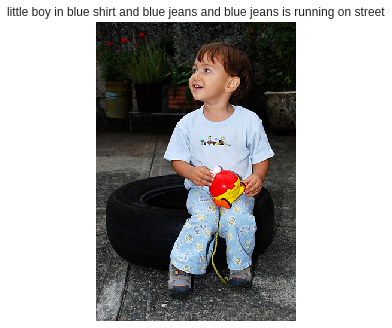

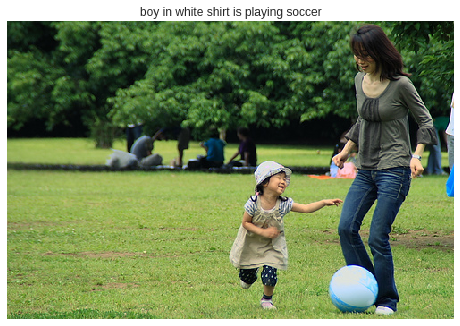

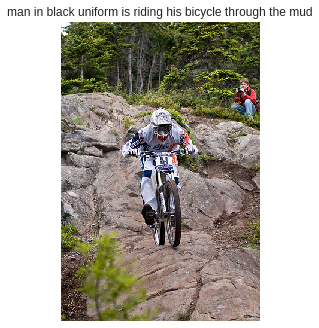

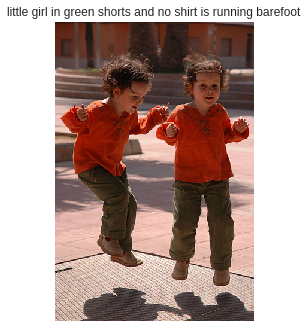

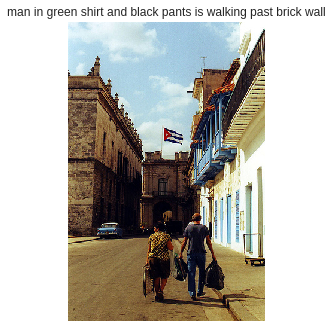

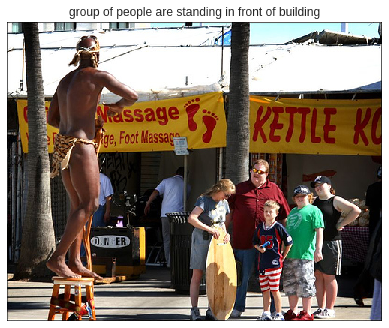

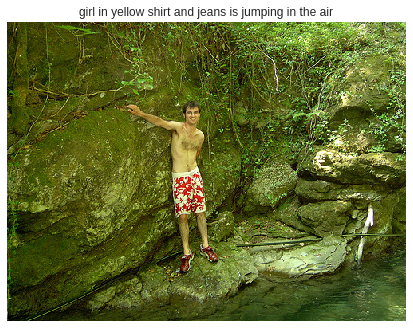

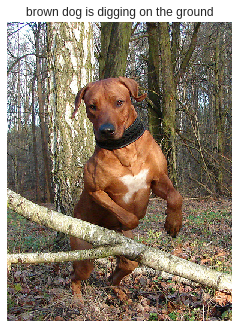

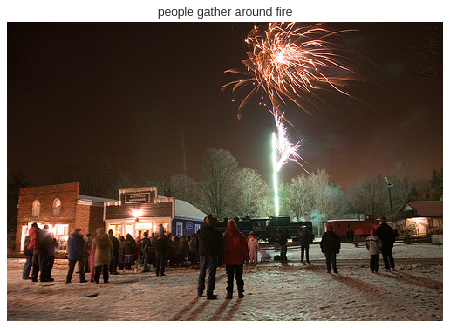

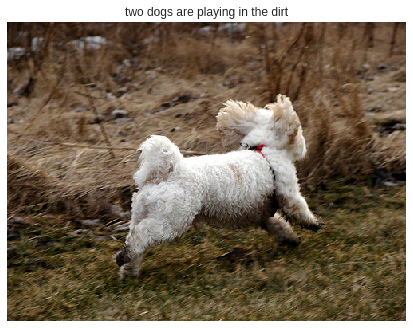

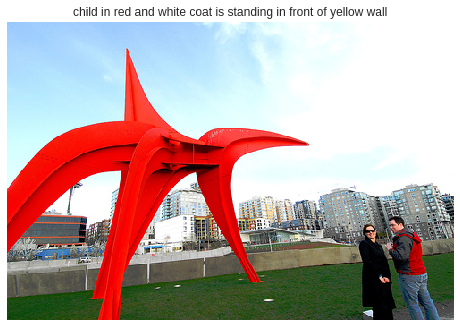

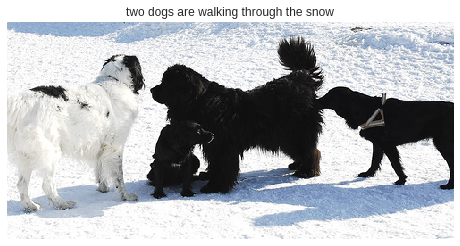

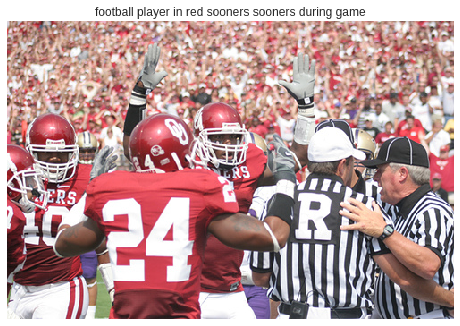

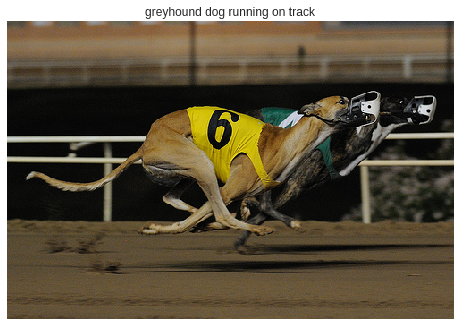

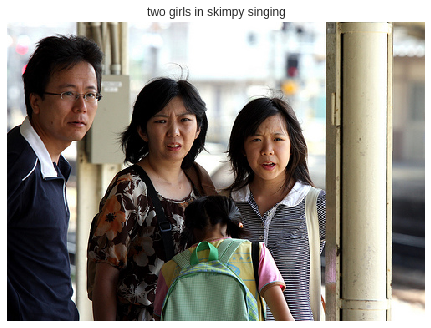

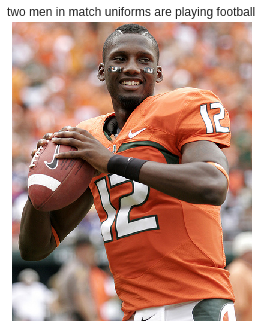

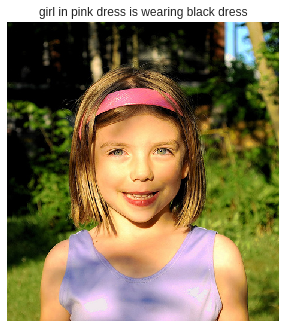

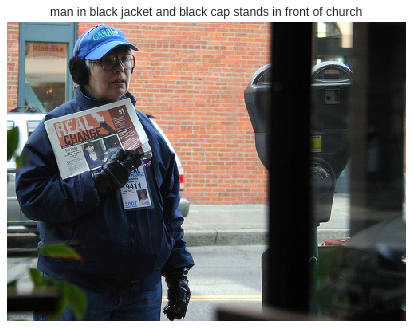

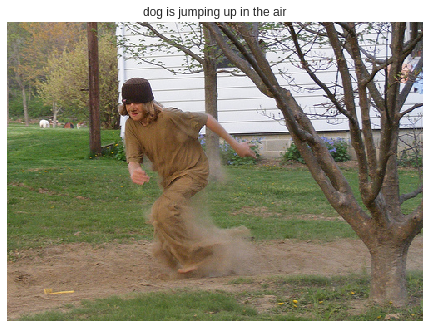

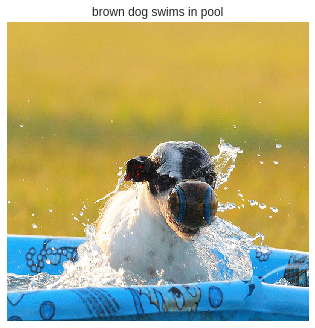

In [62]:
all_images  = list(encoding_test.keys())
for i in range(20):
    idx = np.random.randint(0,1000)
    img_name = all_images[idx]
    img_vector = encoding_test[img_name].reshape((1,2048))
    img = plt.imread('Data/Images/'+img_name+'.jpg')
    cap = predict_caption(img_vector)
    plt.title(cap)
    plt.imshow(img)
    plt.axis('off')
    plt.show()